In [7]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

# !pip install datetime
# !pip install yfinance


years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [8]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Adj Close']

log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
portfolio_value = 1000000

weights = np.array([1/len(tickers)] * len(tickers))

historical_returns = (log_returns * weights).sum(axis=1)
historical_returns

Date
2009-10-20   -0.003395
2009-10-21   -0.003523
2009-10-22    0.005102
2009-10-23   -0.007150
2009-10-26   -0.008538
                ...   
2024-10-09    0.002705
2024-10-10    0.000389
2024-10-11    0.005248
2024-10-14    0.004391
2024-10-15   -0.003119
Length: 3772, dtype: float64

In [10]:
days = 5
print(historical_returns.shape)
historical_x_day_returns = historical_returns.rolling(window=days).sum()
print(historical_x_day_returns.shape)

(3772,)
(3772,)


In [15]:
cov_matrix = log_returns.cov() * 252

print(cov_matrix.shape)

portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

print(cov_matrix)

print(portfolio_std_dev)


(5, 5)
              SPY           BND       GLD       QQQ       VTI
SPY  2.937152e-02  7.664310e-07  0.001614  0.032565  0.029981
BND  7.664310e-07  2.325961e-03  0.002238  0.000214  0.000049
GLD  1.613962e-03  2.237890e-03  0.024342  0.001880  0.001764
QQQ  3.256492e-02  2.139159e-04  0.001880  0.041894  0.033256
VTI  2.998132e-02  4.890329e-05  0.001764  0.033256  0.030851
0.11591530130365786


In [12]:
from scipy.stats import norm

confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

In [13]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $-22,951.40
    95%:          $-28,883.30
    99%:          $-40,010.54


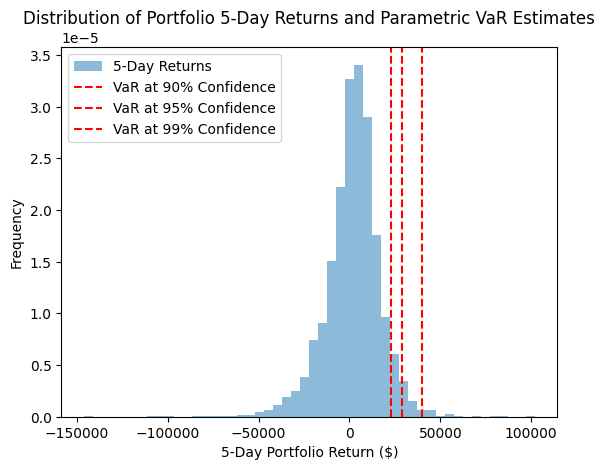

In [14]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()